In [1]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 150

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
# pd.set_option('display.max_rows', None, 'display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
# import the data

df = acquire.get_bach_df()
df = prepare.clean_college_df(df)

# merge and transform for target variable
new_df = prepare.avg_net_price(df)
new_df['major_category'] = new_df.major_name.apply(prepare.categorize_major)

# Ensure you have `2017_2018_2019_earning_by_major.csv` within working folder
new_df = prepare.earnings_merge(new_df)
new_df = prepare.roi_5yr(new_df)
new_df = prepare.roi_10yr(new_df)

new_df.head()

dataframe shape: (71901, 125)


,unit_id_institution,college_name,institution_control,city,state_post_code,zip_code,share_entering_students_first_ft,share_of_part_time,pred_degree,region_ipeds,...,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,roi_10yr
0,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,0.7143,0.7057,14444.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-65075.748698,78598.877181
1,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,0.7143,0.7057,14444.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-65075.748698,78598.877181
2,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,0.3039,0.1409,23696.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-74327.748698,69346.877181
3,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,0.3039,0.1409,23696.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-74327.748698,69346.877181
4,101541.0,Judson College,"Private, nonprofit",Marion,AL,36756,0.7209,0.1622,3.0,5.0,...,0.7385,0.6000,16619.0,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,-67250.748698,76423.877181


In [3]:
# generate a new df for variables i'll be studying

df = new_df[[ 
"college_name",
"institution_control",
"zip_code",
"share_entering_students_first_ft",
"share_of_part_time",
"required_score",
"major_name",
"online_only",
"graduate_number",
"title_IV_student_number",
'other_fam_income_0_30000',
'private_fam_income_0_30000',
'program_fam_income_0_30000',
'pub_fam_income_0_30000',
'other_fam_income_30001_48000',
'private_fam_income_30001_48000',
'program_fam_income_30001_48000',
'pub_fam_income_30001_48000',
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000',
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000',
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000',
"deg_percent_awarded_agriculture_operations",
"deg_percent_awarded_natural_resources",
"deg_percent_awarded_architecture",
"deg_percent_awarded_area_ethnic_cultural_gender",
"deg_percent_awarded_communication_journalism",
"deg_percent_awarded_communication_tech",
"deg_percent_awarded_computer_science",
"deg_percent_awarded_personal_culinary_services",
"deg_percent_awarded_education",
"deg_percent_awarded_engineering",
"deg_percent_awarded_engineering_tech",
"deg_percent_awarded_foreign_language_literatures",
"deg_percent_awarded_human_science",
"deg_percent_awarded_legal_profession",
"deg_percent_awarded_english_lang",
"deg_percent_awarded_general_studies",
"deg_percent_awarded_library_sciences",
"deg_percent_awarded_bio_sciences",
"deg_percent_awarded_mathematics_and_stats",
"deg_percent_awarded_military_tech",
"deg_percent_awarded_intedisciplinary_studies",
"deg_percent_awarded_leisure_fitness",
"deg_percent_awarded_philosophy",
"deg_percent_awarded_theology",
"deg_percent_awarded_physical_sciences",
"deg_percent_awarded_science_tech",
"deg_percent_awarded_psychology",
"deg_percent_awarded_homeland_security",
"deg_percent_awarded_public_admin",
"deg_percent_awarded_social_sciences",
"deg_percent_awarded_construction_trades",
"deg_percent_awarded_mechanic_repair",
"deg_percent_awarded_precision_production",
"deg_percent_awarded_transportation_materials",
"deg_percent_awarded_visual_and_performing_arts",
"deg_percent_awarded_health",
"deg_percent_awarded_business_management",
"deg_percent_awarded_history",
"comp_rt_ft_150over_expected_time_two_races",
"comp_rt_ft_150over_expected_time_native_american",
"comp_rt_ft_150over_expected_time_asian",
"comp_rt_ft_150over_expected_time_black",
"comp_rt_ft_150over_expected_time_hispanic",
"comp_rt_ft_150over_expected_time_non_resident",
"comp_rt_ft_150over_expected_time_unknown_race",
"comp_rt_ft_150over_expected_time_white",
"comp_rt_ft_150over_expected_time",
"enrollment_share_two_races",
"enrollment_share_native_american",
"enrollment_share_asian",
"enrollment_share_black",
"enrollment_share_hispanic",
"enrollment_share_pac_islander",
"enrollment_share_non_resident",
"enrollment_share_unknown",
"enrollment_share_white",
"fedral_loan_full_time_first_time_undergraduate",
"pell_grant_full_time_first_time_undergraduate",
'major_category',
'2017',
'2018',
'2019',
'Grand Total',
'avg_net_price',
'roi_5yr',
'roi_10yr'
]]

# print the shape
df.shape

(71422, 96)

In [4]:
# view the head

df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.7385,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181


In [5]:
# variables needed for socioeconomic study

# lst = pd.Series(['other_fam_income_0_30000', 'private_fam_income_0_30000', 'program_fam_income_0_30000', 'pub_fam_income_0_30000', 'other_fam_income_30001_48000', 'private_fam_income_30001_48000', 'program_fam_income_30001_48000', 'pub_fam_income_30001_48000', 'other_fam_income_48001_75000', 'private_fam_income_48001_75000', 'program_fam_income_48001_75000', 'pub_fam_income_48001_75000', 'other_fam_income_75001_110000', 'private_fam_income_75001_110000', 'program_fam_income_75001_110000', 'pub_fam_income_75001_110000', 'other_fam_income_over_110000', 'private_fam_income_over_110000', 'program_fam_income_over_110000', 'pub_fam_income_over_110000'])
# lst.tolist()

In [6]:
# collapse avg net price to one column

def avg_net_price(df):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df['avg_net_price_public'] = df['avg_net_price_public'].fillna(0)

    df['avg_net_price_private'] = df['avg_net_price_private'].fillna(0)

    df['avg_net_price'] = df.avg_net_price_public + df.avg_net_price_private

    # return the dataframe
    return df

In [7]:
# income brackets

income_0_30000 = [
'other_fam_income_0_30000',
 'private_fam_income_0_30000',
 'program_fam_income_0_30000',
 'pub_fam_income_0_30000']

income_30001_48000 = [
 'other_fam_income_30001_48000',
 'private_fam_income_30001_48000',
 'program_fam_income_30001_48000',
 'pub_fam_income_30001_48000']

income_48001_75000 = [
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000']

income_75001_110000 = [
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000']

income_over_110000 = [
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000']

In [8]:
# used as reference

def get_fam_income_col(df, s1, s2, s3, s4):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df[s1] = df[s1].fillna(0)

    df[s2] = df[s2].fillna(0)

    df[s3] = df[s3].fillna(0)

    df[s4] = df[s4].fillna(0)

    df['family_income_0_30000'] = df[s1] + df[s2] + df[s3] + df[s4]

    # drop redundant columns
    df = df.drop(columns = [s1, s2, s3, s4])

    # return the dataframe
    return df

In [9]:
# create a "collapse" cols function

def get_fam_income_col(df, col_lst, new_col_string):

    '''Function that creates a new family income columns from 
    existing dummy columns.'''

    df[col_lst] = df[col_lst].fillna(0)

    df[new_col_string] = df[col_lst].sum(axis = 1)

    # drop redundant columns
    df = df.drop(df[col_lst], axis = 1)

    # return the dataframe
    return df

In [10]:
df.shape

(71422, 96)

In [11]:
# splitting the dataset

s1 = 'other_fam_income_0_30000'
s2 = 'private_fam_income_0_30000'
s3 = 'program_fam_income_0_30000'
s4 = 'pub_fam_income_0_30000'

df = get_fam_income_col(df, income_0_30000, "fam_income_0_30000")
df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181,20.0


In [12]:
# check the shape

df.shape # checks out

(71422, 93)

In [13]:
# running function for remaining fam_income_variables

# list of cols to collapse
frames = [
    income_30001_48000, 
    income_48001_75000, 
    income_75001_110000, 
    income_over_110000]

# list of new col names
var_names = [
    'income_30001_48000', 
    'income_48001_75000', 
    'income_75001_110000', 
    'income_over_110000']

for i in range(len(frames)):
    var_name = var_names[i]
    df = get_fam_income_col(df, frames[i], var_name)

print(df.shape)
df.head()

(71422, 81)


,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0,113.0,61.0,27.0,16.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,-65075.748698,78598.877181,375.0,113.0,61.0,27.0,16.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0,155.0,166.0,201.0,364.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,-74327.748698,69346.877181,254.0,155.0,166.0,201.0,364.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,61388.93381,174512.4921,16619.0,-67250.748698,76423.877181,20.0,10.0,10.0,10.0,8.0


In [14]:
# checking percentage of nulls across features
null_percentages = df.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
title_IV_student_number                             0.47
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_cu

In [15]:
 # create list to collapse by genre
 
# deg_lst = list(null_percentages.iloc[null_percentages.index.str.startswith("deg_percent_awarded_")].index)

In [16]:
# check the shape

df.shape

(71422, 81)

In [17]:
# dropping title_IV_student_number which has a significantly high percentage of missing values/records

df = df.drop(columns = "title_IV_student_number")
df.shape

(71422, 80)

In [18]:
# split the data function

def split_data(df):
    
    train_and_validate, test = train_test_split(
                                                df, 
                                                test_size = 0.2, 
                                                random_state = 123,
                                                stratify = df["major_category"])

    train, validate = train_test_split(
                                    train_and_validate,
                                    test_size = 0.3,
                                    random_state = 123,
                                    stratify = train_and_validate["major_category"])

    print(f'train shape: {train.shape}')
    print(f'validate shape: {validate.shape}')
    print(f'test shape: {test.shape}')

    return train, validate, test

In [19]:
# splitting the data

train, validate, test = split_data(df)

train shape: (39995, 80)
validate shape: (17142, 80)
test shape: (14285, 80)


In [20]:
# recheck nulls

null_percentages = train.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)# identify columns with > 10% missing records

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_culinary_services      0.04
deg_percent_awarded_education  

In [21]:
# identify features with greater than 10% missing records

container = []

for i in range(len(null_percentages.values)):
    if null_percentages[i] > .1:

        container.append(null_percentages.index[i])

container

['required_score',
 'graduate_number',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race']

In [22]:
# check percentage of nulls for numerical columns

check_nulls = train[train.select_dtypes(include = "number").columns]

In [23]:
# retrieving numerical column lower/upper bound outliers
# with pd.option_context('display.max_rows', None):

pd.set_option('display.max_rows', None)

def get_outliers_table(df, k = 1.5):
    '''Function to loop through dataframe and return
    continuous variable outliers outside of Q1 and Q3 using of an IQR method.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    holder = []

    # determining continuous features/columns
    for col in train[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = train[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        metrics = { 
            "column": col,
            "column type": train[col].dtype,
            "iqr": round(iqr, 5),
            "lower_bound": round(lower_bound, 5),
            "lower_outliers": len(train[train[col] < lower_bound]),
            "upper_bound": round(upper_bound, 5),
            "upper_outliers": len(train[train[col] > upper_bound])
        }

        holder.append(metrics)

    num_outliers = pd.DataFrame(holder)
    num_outliers = num_outliers.sort_values(by = [ "upper_outliers", "lower_outliers"], ascending = False)

    return num_outliers

num_outliers = get_outliers_table(train)
num_outliers

,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
15,deg_percent_awarded_engineering_tech,float64,0.00110,-0.00165,0,0.00275,9086
2,required_score,float64,0.00000,1.00000,0,1.00000,7501
7,deg_percent_awarded_architecture,float64,0.00000,0.00000,0,0.00000,7130
18,deg_percent_awarded_legal_profession,float64,0.00000,0.00000,0,0.00000,7126
17,deg_percent_awarded_human_science,float64,0.00690,-0.01035,0,0.01725,6988
5,deg_percent_awarded_agriculture_operations,float64,0.00000,0.00000,0,0.00000,6649
28,deg_percent_awarded_theology,float64,0.00000,0.00000,0,0.00000,6120
8,deg_percent_awarded_area_ethnic_cultural_gender,float64,0.00320,-0.00480,0,0.00800,4785
10,deg_percent_awarded_communication_tech,float64,0.00000,0.00000,0,0.00000,3974
20,deg_percent_awarded_general_studies,float64,0.03850,-0.05775,0,0.09625,3964


In [24]:
drop_outliers = num_outliers[(num_outliers["lower_outliers"] == 0) & (num_outliers["upper_outliers"] == 0)].index

num_outliers = num_outliers.drop(drop_outliers)
num_outliers

,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
15,deg_percent_awarded_engineering_tech,float64,0.00110,-0.00165,0,0.00275,9086
2,required_score,float64,0.00000,1.00000,0,1.00000,7501
7,deg_percent_awarded_architecture,float64,0.00000,0.00000,0,0.00000,7130
18,deg_percent_awarded_legal_profession,float64,0.00000,0.00000,0,0.00000,7126
17,deg_percent_awarded_human_science,float64,0.00690,-0.01035,0,0.01725,6988
5,deg_percent_awarded_agriculture_operations,float64,0.00000,0.00000,0,0.00000,6649
28,deg_percent_awarded_theology,float64,0.00000,0.00000,0,0.00000,6120
8,deg_percent_awarded_area_ethnic_cultural_gender,float64,0.00320,-0.00480,0,0.00800,4785
10,deg_percent_awarded_communication_tech,float64,0.00000,0.00000,0,0.00000,3974
20,deg_percent_awarded_general_studies,float64,0.03850,-0.05775,0,0.09625,3964


In [25]:
from scipy.stats.mstats import winsorize

def percentile_capping(df, low_end, high_end):
    '''Function that uses scipy's winsorize method to cap
    continuous variables at lower and higher end based on a passed 
    percentile value.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

    # dont include target variables to cap
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total"]

    col_lst = [col for col in l1 if col not in target_lst]

    for col in col_lst:
        stats.mstats.winsorize(
            a = df[col], 
            limits = (low_end, high_end), 
            inplace = True)


In [26]:
# test out the function

percentile_capping(train, 0.05, 0.05)
num_outliers = get_outliers_table(train)

# inspect the functions worked
num_outliers

,column,column type,iqr,lower_bound,lower_outliers,upper_bound,upper_outliers
7,deg_percent_awarded_architecture,float64,0.00000,0.00000,0,0.00000,8776
18,deg_percent_awarded_legal_profession,float64,0.00000,0.00000,0,0.00000,8772
5,deg_percent_awarded_agriculture_operations,float64,0.00000,0.00000,0,0.00000,8295
15,deg_percent_awarded_engineering_tech,float64,0.00520,-0.00780,0,0.01300,8254
28,deg_percent_awarded_theology,float64,0.00000,0.00000,0,0.00000,7766
2,required_score,float64,0.00000,1.00000,0,1.00000,7501
17,deg_percent_awarded_human_science,float64,0.01190,-0.01785,0,0.02975,6527
10,deg_percent_awarded_communication_tech,float64,0.00000,0.00000,0,0.00000,5620
8,deg_percent_awarded_area_ethnic_cultural_gender,float64,0.00410,-0.00615,0,0.01025,5560
57,enrollment_share_pac_islander,float64,0.00210,-0.00265,0,0.00575,4910


In [27]:
# capping outliers

def handle_outliers(df, k = 1.5):
    '''Function determines outliers based on "iqr" and then handles outliers
    by transforming these observations to the mean.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    # determining continuous features/columns
    for col in df[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = df[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        # avg value
        avg_value = df[col].mean()

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x < lower_bound else x)

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x > upper_bound else x)
    
        # renaming the column to reflect capping
        # df.rename(columns = {col: col + "_transformed"}, inplace = True)

    # returning the updated dataframe
    return df

In [28]:
# capping records at lower and upper bounds
# train = handle_outliers(train)
# num_outliers = get_outliers_table(train)

# # inspect the functions worked
# num_outliers

In [29]:
# capping validate and test dfs

percentile_capping(validate, 0.05, 0.05)
percentile_capping(test, 0.05, 0.05)

In [30]:
# create the imputer

def train_iterative_imputer(train_df):

        # placeholder for continuous features
        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        # dont learn from these variables
        target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total"
        ]
        
        num_lst = [col for col in l1 if col not in target_lst]
        
        # creating the "thing"
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)
        
        # fitting the "thing" and transforming it
        imputed = imputer.fit_transform(train_df[num_lst])

           # create a new dataframe with learned imputed data
        train_df_imputed = pd.DataFrame(imputed, index = train_df.index)

        # filling in missing values from learned imputer
        train_df[num_lst] = train_df_imputed

        # return the new imputed df
        return train_df

In [31]:
# handling remaining null values using sklearn's iterative imputer

train_imputed = train_iterative_imputer(train)

# retuning remaining nulls
remaining_nulls = train_imputed.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(remaining_nulls) # zip codes still missing

KeyboardInterrupt: 

In [ ]:
# impute zip codes by mode

train_imputed["zip_code"] = train_imputed["zip_code"].fillna(train_imputed["zip_code"].mode()[0])
print(f'zip_code missing values: {train_imputed.zip_code.isnull().sum()}') # checks out

zip_code missing values: 0


In [ ]:
# shape
train_imputed.shape

(39995, 80)

In [ ]:
# can do the same across validate and test datasets

def impute_val_and_test(train_df, val_df, test_df):
        
        '''Function takes in all three split datasets and imputes missing values in validate and test after
        fitting on training dataset columns'''

        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total"
        ]

        # recheck cols are not in target list
        num_lst = [col for col in l1 if col not in target_lst]

        # creating the sklearn imputer
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)

        # fitting the imputer
        imputed = imputer.fit(train_df[num_lst])

        # transforming values
        val_imputed = imputed.transform(val_df[num_lst])
        X_validate_imputed = pd.DataFrame(val_imputed, index = val_df.index)
        val_df[num_lst] = X_validate_imputed
        validate_imputed = val_df

        test_imputed = imputed.transform(test_df[num_lst])
        test_imputed = pd.DataFrame(test_imputed, index = test_df.index)
        test_df[num_lst] = test_imputed
        test_imputed = test_df

        # fill-in any instances of missing zip-code values
        validate_imputed["zip_code"] = validate_imputed["zip_code"].fillna(validate_imputed["zip_code"].mode()[0])
        test_imputed["zip_code"] = test_imputed["zip_code"].fillna(test_imputed["zip_code"].mode()[0])


        # returning the imputed validate and test datasets
        return validate_imputed, test_imputed

In [ ]:
# look at train

train.shape
train.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,deg_percent_awarded_agriculture_operations,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
25530,University of Memphis,Public,38152,0.6227,0.2274,1.0,Journalism.,0.0,4225.0,0.0000,...,58348.57445,169831.2865,13048.0,-74625.310753,52258.720623,790.0,346.0,248.0,186.0,209.0
53875,Limestone University,"Private, nonprofit",29340-3799,0.5654,0.2116,1.0,Communication and Media Studies.,0.0,67.0,0.0000,...,66997.75002,191767.4743,24083.0,-45903.361529,128746.339159,106.0,51.0,57.0,39.0,49.0
42932,Texas State University,Public,78666,0.6166,0.1797,1.0,Design and Applied Arts.,0.0,4457.0,0.0122,...,53039.54507,152893.5207,14692.0,-104145.800598,-6581.250562,790.0,387.0,392.0,376.0,663.0
45495,Judson University,"Private, nonprofit",60123-1498,0.4158,0.3243,1.0,Accounting and Related Services.,0.0,222.0,0.0000,...,79608.39225,231146.3982,20498.0,23043.529582,267336.372751,28.0,16.0,37.0,29.0,28.0
25003,Yeshiva University,"Private, nonprofit",10033-3299,0.9601,0.0183,1.0,"Classics and Classical Languages, Literatures,...",0.0,3751.0,0.0000,...,58348.57445,169831.2865,32994.0,-97991.310753,28892.720623,58.0,26.0,34.0,34.0,97.0


In [ ]:
# impute missing values in validate and test 

validate_imputed, test_imputed = impute_val_and_test(train, validate, test)
print(f'validate shape: {validate_imputed.shape}')
print(f'test shape: {test_imputed.shape}')

validate shape: (17142, 80)
test shape: (14285, 80)


----
### ``Target Variable Distribution``

5 YEAR ROI 

10 YEAR ROI

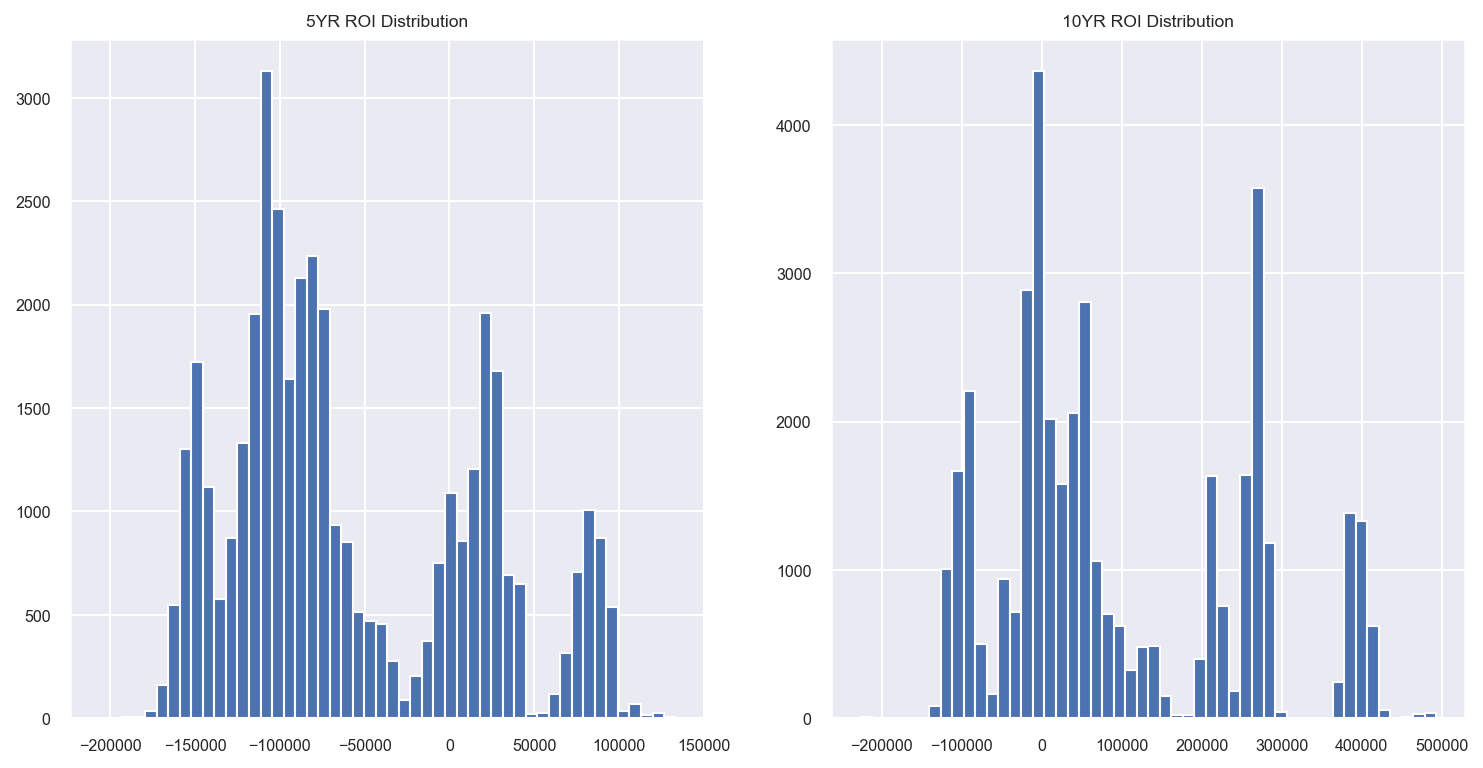

In [ ]:
# side-by-side comparison

plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plt.subplot(121)
plt.title("5YR ROI Distribution")
plt.hist(train_imputed["roi_5yr"], bins = 50)

plt.subplot(122)
plt.title("10YR ROI Distribution")
plt.hist(train_imputed["roi_10yr"], bins = 50)

plt.show()


``Hypothesis Question #1: ``

**Is there a difference in ROI earnings across public/private/’other’ controlled institutions?**

Null Hypothesis: "There's not a statistical 5-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 5-year Major ROI difference difference across institution control."

----

Null Hypothesis: "There's not a statistical 10-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 10-year Major ROI difference difference across institution control."


alpha: 0.05

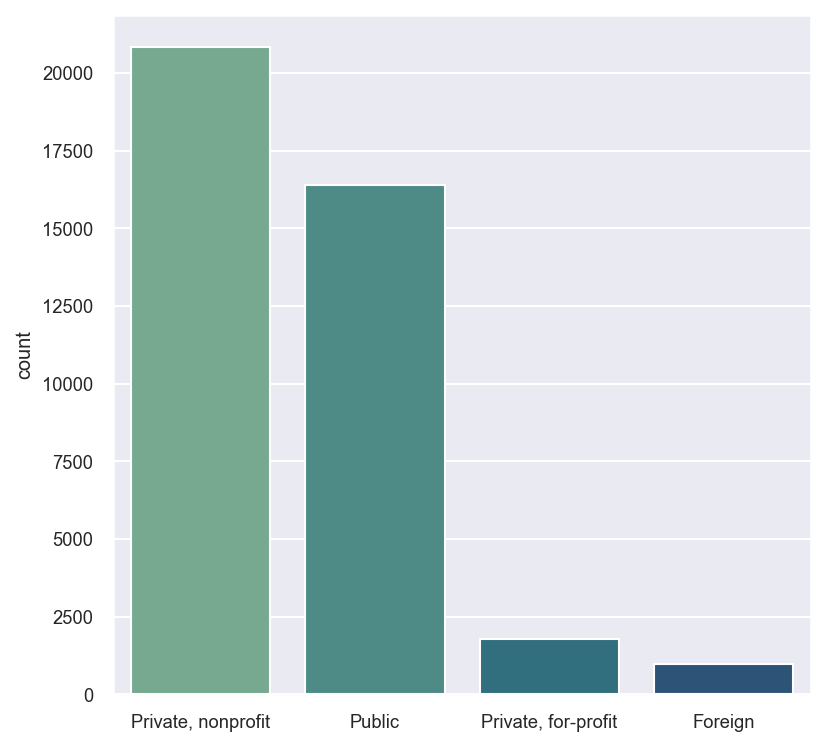

In [ ]:
# viewing institution control by the numbers

plt.figure(figsize=(6, 6))
sns.set(font_scale = .8)

sns.countplot(
    train_imputed["institution_control"],
    order = train_imputed["institution_control"].value_counts().index,
    palette="crest")

plt.xlabel(None)
plt.show()

In [ ]:
# observations 
# private - non for profit wins out with most records in the training dataset
# where foreign is the least number of observations

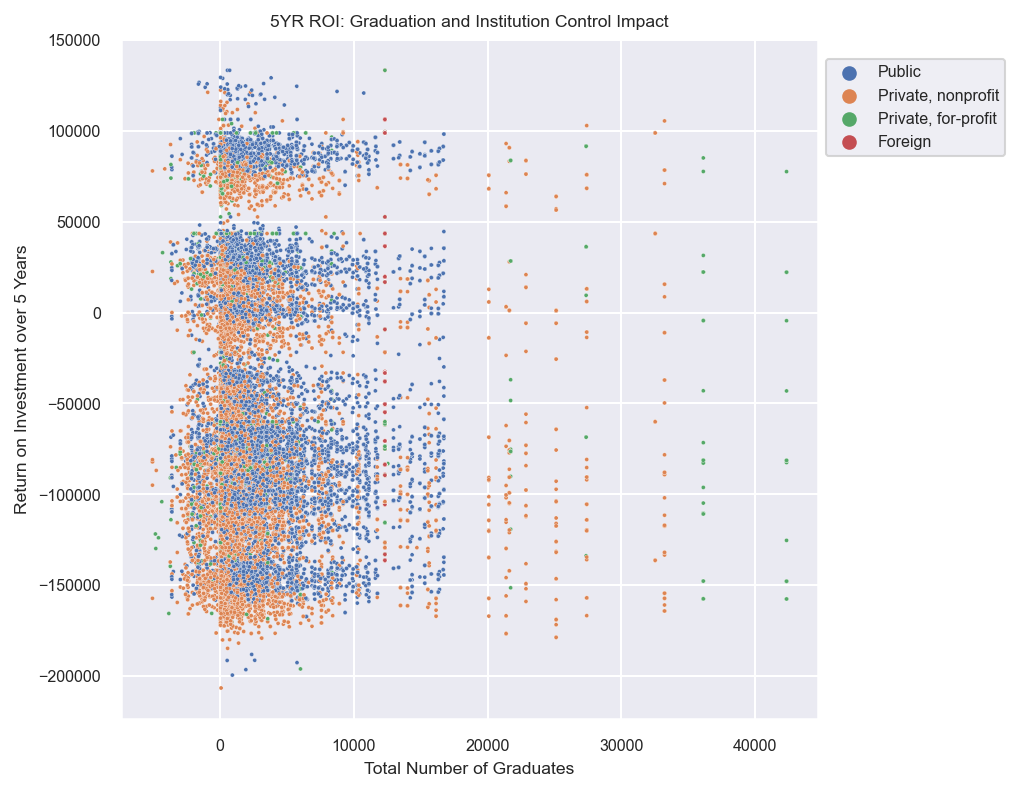

In [ ]:
# plotting institution control type by 5_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_5yr"],
    data = train_imputed,
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("5YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

In [ ]:
train_imputed["graduate_number"]

25530     4225.000000
53875       67.000000
42932     4457.000000
45495      222.000000
25003     3751.000000
2986      1112.326070
3803     14350.000000
60558      770.000000
19927      649.000000
67684     7078.000000
54795      924.000000
51665      717.000000
26418      647.000000
33315       54.000000
30870     5461.000000
17980      327.000000
27589     3012.000000
31093     1612.000000
12167      587.000000
53814      509.000000
16371       38.000000
10708      609.000000
19377      254.000000
3280       225.000000
53440      904.000000
61688     5130.000000
12975     4009.000000
29350      518.000000
33953     3183.000000
70490    11648.000000
19208     1064.000000
35350     6866.000000
48328     1513.000000
31999     3138.000000
26533       39.000000
44605     8073.000000
36513     3114.000000
62251     1049.000000
35713     3611.000000
47777      988.000000
1948      -445.036941
35035     4236.000000
39806     2227.000000
63858      167.000000
22635     1469.840282
38251    1

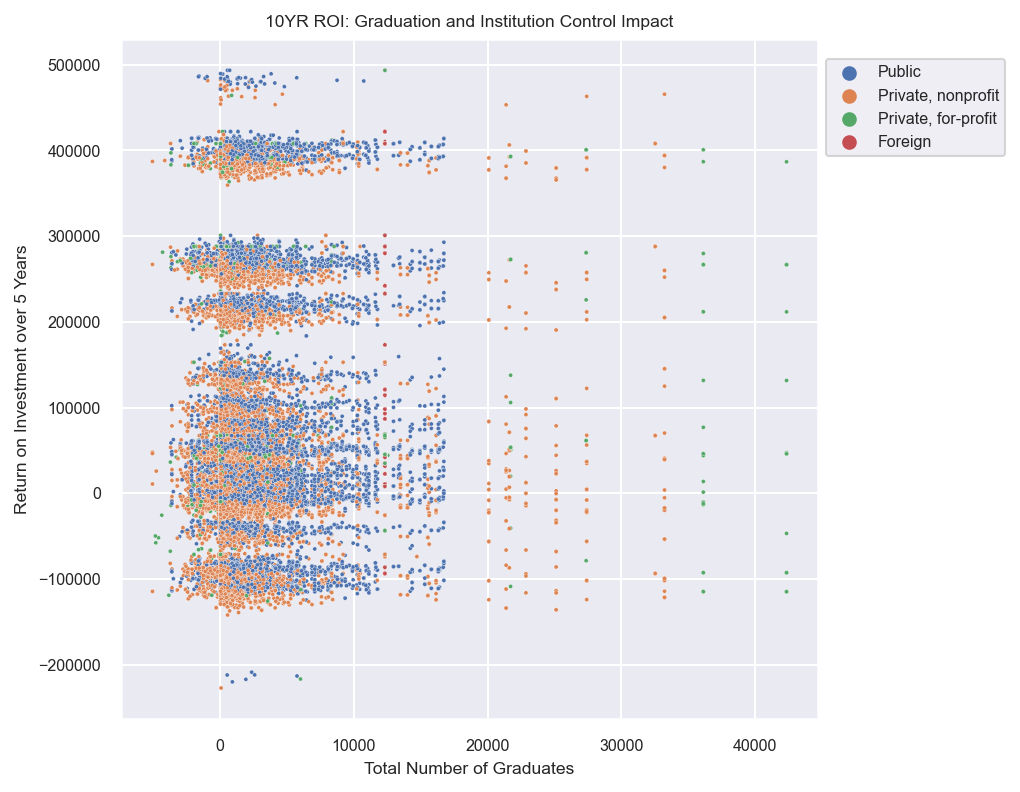

In [ ]:
# plotting institution control type by 10_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_10yr"],
    data = train_imputed[train_imputed["graduate_number"] != 0],
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("10YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

In [ ]:
train_imputed["major_category"].unique().tolist()

['English Language, Literature, and Composition',
 'Communications',
 'Fine Arts',
 'Business',
 'Biology and Life Sciences',
 'Medical and Health Sciences and Services',
 'Education Administration and Teaching',
 'Interdisciplinary and Multi-Disciplinary Studies (General)',
 'Linguistics and Foreign Languages',
 'Liberal Arts and Humanities',
 'Social Sciences',
 'Physical Fitness, Parks, Recreation, and Leisure',
 'Mathematics and Statistics',
 'Communication Technologies',
 'Computer and Information Sciences',
 'Public Affairs, Policy, and Social Work',
 'Law',
 'Criminal Justice and Fire Protection',
 'History',
 'Engineering',
 'Theology and Religious Vocations',
 'Psychology',
 'Environment and Natural Resources',
 'Philosophy and Religious Studies',
 'Engineering Technologies',
 'Physical Sciences',
 'Electrical and Mechanic Repairs and Technologies',
 'Area, Ethnic, and Civilization Studies',
 'Agriculture',
 'Military Technologies',
 'Cosmetology Services and Culinary Arts',
 

In [ ]:
# 5YR/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    pub_mean = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_profit_mean = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_nonprofit_mean = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    foreign_mean = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_5yr"].values

    # extend values
    pub_container.extend(pub_mean)
    pri_profit_container.extend(pri_profit_mean)
    pri_nonprofit_container.extend(pri_nonprofit_mean)
    forein_container.extend(foreign_mean)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [ ]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 404.30763
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


In [ ]:
# 10yr/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    pub_mean = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_profit_mean = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_nonprofit_mean = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    foreign_mean = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_10yr"].values

    # extend values
    pub_container.extend(pub_mean)
    pri_profit_container.extend(pri_profit_mean)
    pri_nonprofit_container.extend(pri_nonprofit_mean)
    forein_container.extend(foreign_mean)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [ ]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 265.76735
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


``observations:``

A college's institutional control is statistically significant in potentially predicting a student's 5 and 10 year ROI

In [ ]:
# what about number of graduates?

pd.qcut(
    train_imputed["graduate_number"],
    q = 4).unique()